In [97]:
import random
import pandas as pd
import scipy.stats
import numpy as np
import math

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

import pymc3 as pm

import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/Users/ryand/Downloads/russian-wholesale-electricity-market/RU_Electricity_Market_PZ_dayahead_price_volume.csv', parse_dates=['timestep'])

In [8]:
for col in ['price_eur','price_sib']:
    df[col] = df[col].apply(lambda x: float(x.replace(',','')))

# Explore

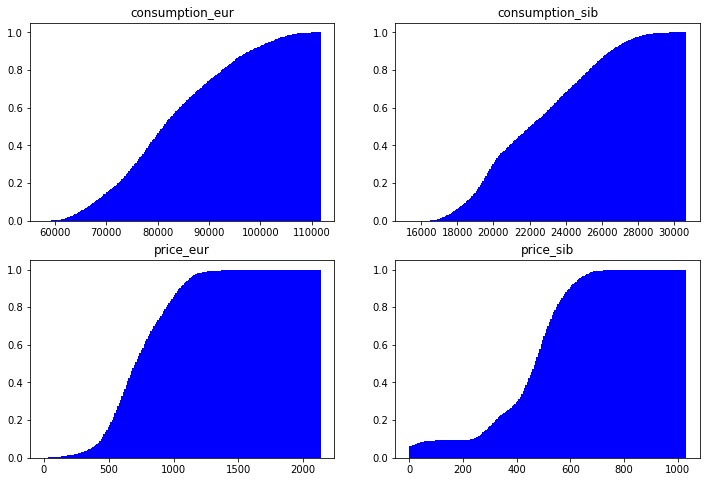

In [114]:
fig, ax = plt.subplots(2,2,figsize=(12,8))
for i, col in enumerate(['consumption_eur','consumption_sib','price_eur','price_sib']):
    seg = 0 if i < 2 else 1
    ax[seg][i-seg*2].hist(df[col],
                          color='blue',
                          cumulative=True,
                          density=1,
                          bins=200)
    ax[seg][i-seg*2].set_title(col)

In [115]:
import scipy.stats
tb = scipy.stats.norm.cdf#(x, loc=mu, scale=sigma)

In [129]:
cdf = scipy.stats.norm.cdf(df['consumption_eur'].sort_values(),
                           loc=df['consumption_eur'].mean(), 
                           scale=df['consumption_eur'].std())

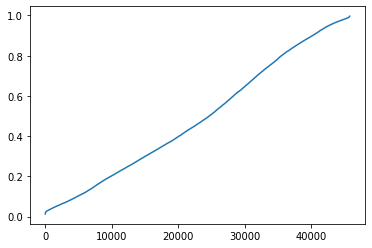

In [131]:
fig, ax = plt.subplots(1,1)
ax.plot(range(0,len(cdf)),cdf)

In [132]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)
    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

In [133]:
Cov(xs=df['consumption_eur'],ys=df['price_eur'])

804862.72303513

In [136]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    meanx, varx = np.mean(xs), np.var(xs)
    meany, vary = np.mean(ys), np.var(ys)
    corr = Cov(xs, ys, meanx, meany) / math.sqrt(varx * vary)
    return corr

In [139]:
Corr(xs=df['consumption_eur'],ys=df['price_eur'])

0.30463921349765677

In [ ]:
np.linalg.norm(df['consumption_eur'])

# From book

In [72]:
df = pd.read_csv('/Users/ryand/Downloads/wine-reviews/winemag-data_first150k.csv').sort_values('price')
del df['Unnamed: 0']

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150930 entries, 90546 to 150922
Data columns (total 10 columns):
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 12.7+ MB


In [75]:
for feature in ['country','province','variety','winery']:
    le = preprocessing.LabelEncoder()
    le.fit((df[feature].fillna('').tolist()))
    le.classes_
    df['{}_enc'.format(feature)] = le.transform(df[feature].fillna(''))

In [76]:
feature_cols = []
for col in df.columns:
    if type(df[col].dropna().tolist()[0]) in [float,int]:
        feature_cols.append(col)
feature_cols

['points', 'price', 'country_enc', 'province_enc', 'variety_enc', 'winery_enc']

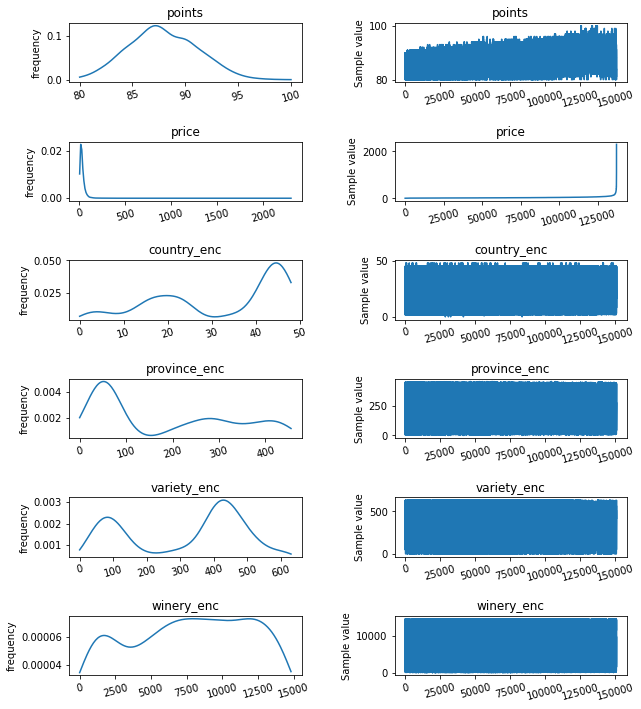

In [78]:
fig, ax = plt.subplots(len(feature_cols),2,figsize=(10,len(feature_cols)*2))
for i, feature in enumerate(feature_cols):
    ax_ = ax[i]
    density = scipy.stats.gaussian_kde(df[feature].dropna())
    xs = np.linspace(min(df[feature].dropna()), max(df[feature].dropna()), 200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    ax_[0].plot(xs,density(xs))
    ax_[0].set_ylabel('frequency')
    ax_[1].plot(range(0,len(df[feature])),df[feature])
    ax_[1].set_ylabel('Sample value')
    for ax_plot in ax_:
        ax_plot.set_title(feature)
        for tick in ax_plot.get_xticklabels():
            tick.set_rotation(15)
plt.subplots_adjust(wspace=.4, hspace=1)

In [102]:
dum = pd.get_dummies(df['country'])
df_dum = df.join(dum)

In [104]:
df_dum.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,...,South Africa,South Korea,Spain,Switzerland,Tunisia,Turkey,US,US-France,Ukraine,Uruguay
90546,Argentina,Clean as anyone should reasonably expect given...,NaN,85,4.0,Mendoza Province,Mendoza,NaN,Malbec,Toca Diamonte,...,0,0,0,0,0,0,0,0,0,0
25645,US,"There's a lot going on in this Merlot, which i...",NaN,86,4.0,California,California,California Other,Merlot,Bandit,...,0,0,0,0,0,0,1,0,0,0
118347,US,"Light and earthy, this wine-in-a-box is clean ...",NaN,84,4.0,California,California,California Other,Cabernet Sauvignon,Bandit,...,0,0,0,0,0,0,1,0,0,0
1858,US,"Sweet and fruity, this canned wine feels soft ...",Unoaked,83,4.0,California,California,California Other,Chardonnay,Pam's Cuties,...,0,0,0,0,0,0,1,0,0,0
91766,Argentina,"Crimson in color but also translucent, with a ...",Red,84,4.0,Mendoza Province,Mendoza,NaN,Malbec-Syrah,Broke Ass,...,0,0,0,0,0,0,0,0,0,0


In [115]:
X = df_dum[['price','points'] + dum.columns.tolist()].dropna()
y = X['points']
del X['points']

In [129]:
reg = LinearRegression(fit_intercept=False).fit(X,y)

In [131]:
reg.score(X,y)

0.21556523942432249

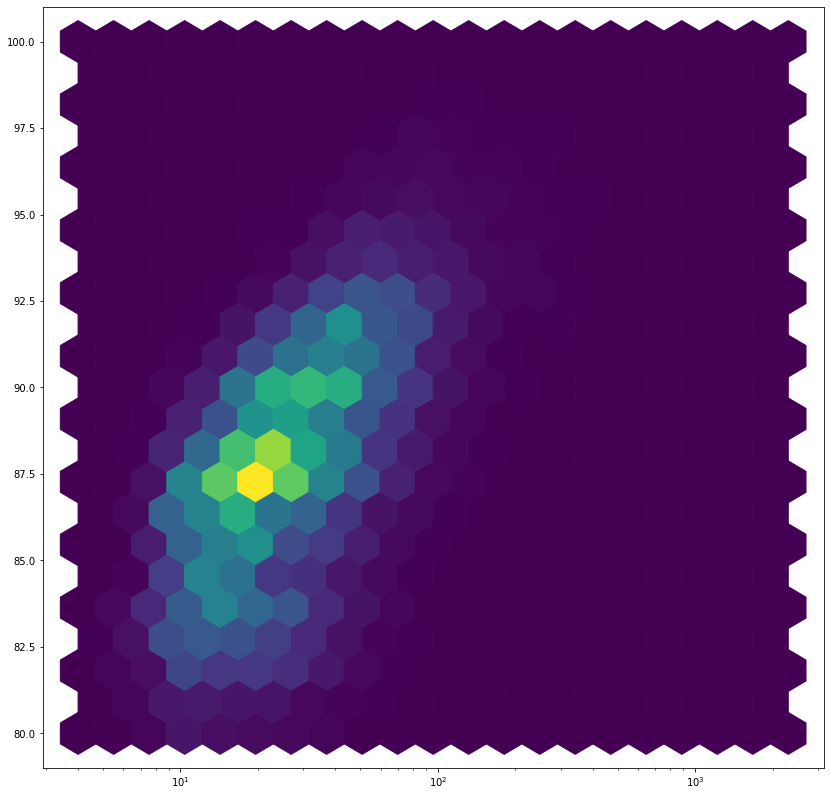

In [205]:
fig, ax = plt.subplots(1,1,figsize=(14,14))
ax.hexbin(df['price'],df['points'], gridsize=20,xscale='log')#,yscale='log')

In [174]:
counts=df['province'].value_counts()

Text(0.5, 1.0, 'Price')

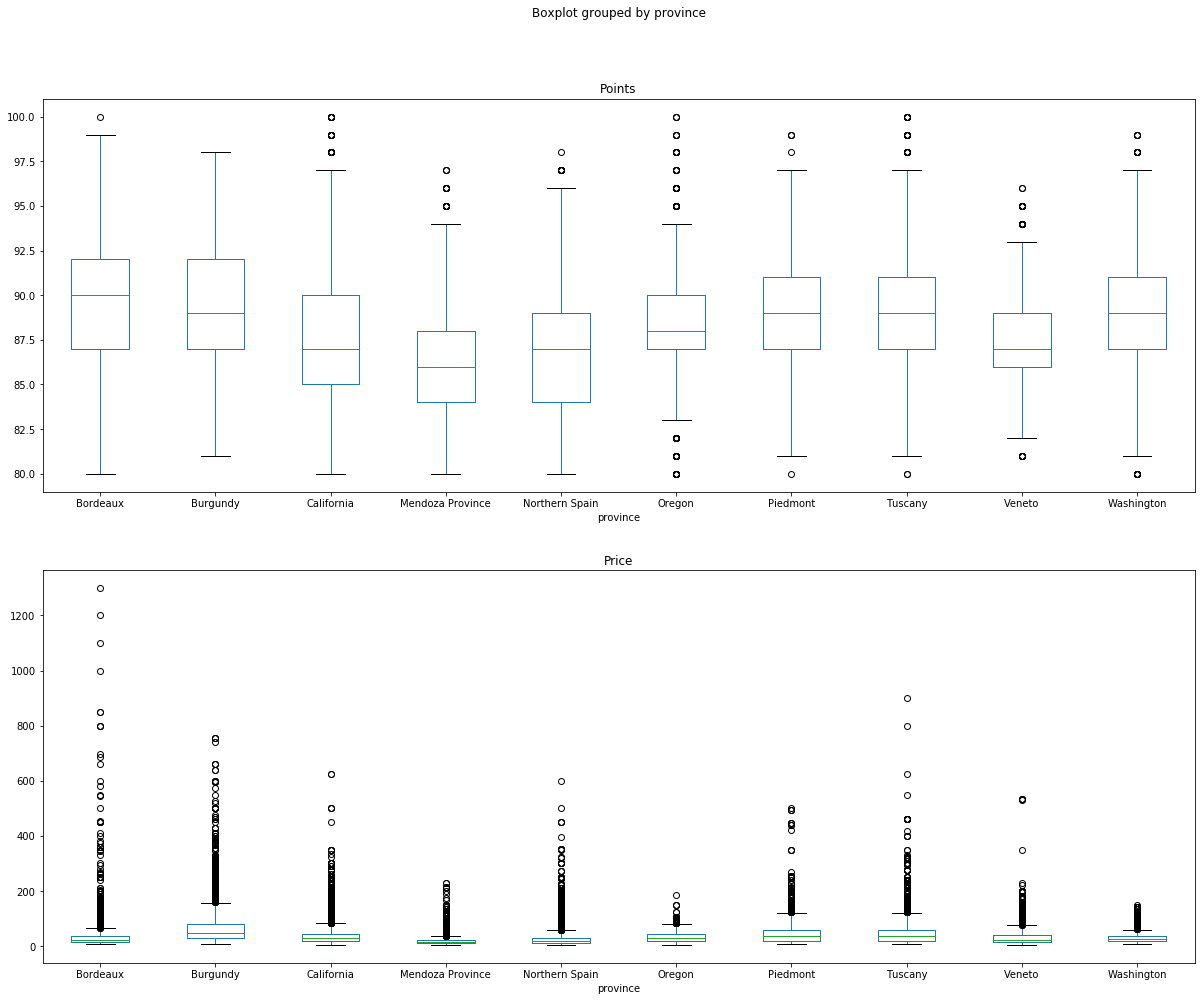

In [224]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,16))
df[df['province'].isin(counts[counts > counts.mean()].head(10).index.tolist())].boxplot(column='points',
                                                                                        by='province',
                                                                                        grid=False,
                                                                                        ax=ax1,)
df[(df['province'].isin(counts[counts > counts.mean()].head(10).index.tolist())) & (df['price'] <1500)].boxplot(column='price',
                                                                                        by='province',
                                                                                        grid=False,
                                                                                        ax=ax2,)
ax1.set_title('Points')
ax2.set_title('Price')

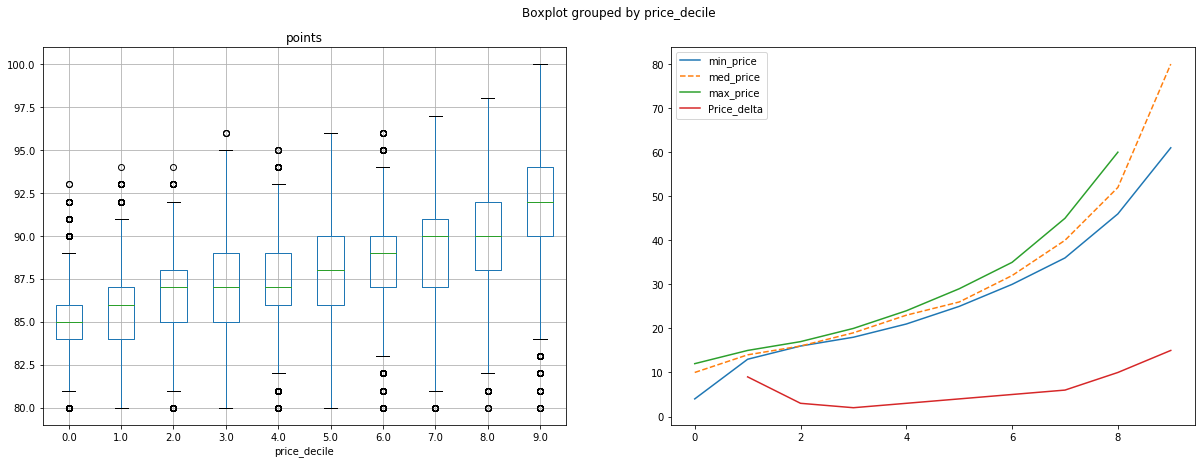

In [275]:
# Set a column with decile values based on price
df['price_decile'] = pd.qcut(df['price'], 10, labels=False)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))
df.boxplot(column='points',
           by='price_decile',
           ax=ax1)
min_dec_prices = df.groupby('price_decile').min()['price']
med_dec_prices = df.groupby('price_decile').median()['price']
max_dec_prices = df.groupby('price_decile').max()['price']
price_deltas = min_dec_prices - min_dec_prices.shift(1)
ax2.plot(min_dec_prices.index,min_dec_prices, label='min_price')
ax2.plot(med_dec_prices.index,med_dec_prices, ls='--', label='med_price')
ax2.plot(max_dec_prices.index.tolist()[:-1],max_dec_prices.tolist()[:-1], label='max_price')
ax2.plot(price_deltas.index,price_deltas, label='Price_delta')
ax2.legend(loc=2)

# By Category

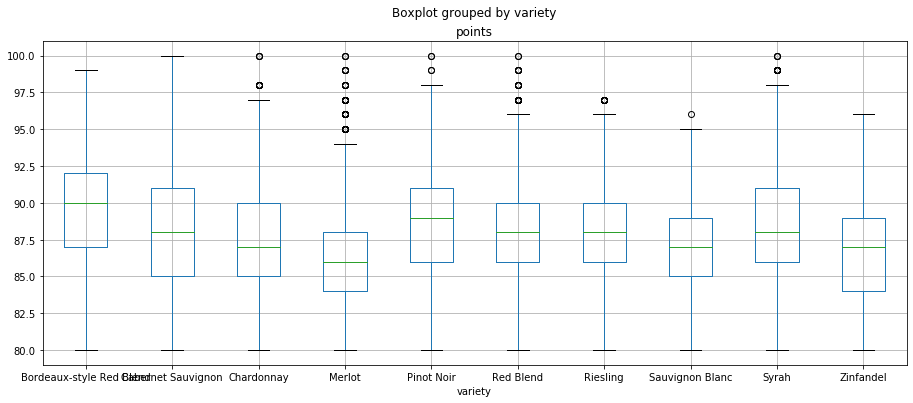

In [290]:
df[df['variety'].isin(df['variety'].value_counts().head(10).index.tolist())].boxplot(column='points',
                                                                                     by='variety',
                                                                                     figsize=(15,6))

In [294]:
df.columns

Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'variety', 'winery', 'country_enc',
       'province_enc', 'variety_enc', 'winery_enc', 'price_decile'],
      dtype='object')

In [307]:
for column in ['country','designation','province','region_1','variety','winery']:
    print('{}: {}|{}'.format(column, round(df.groupby(column).std()[['points']].mean()['points'],2),round(df.groupby(column).std()[['points']].median()['points'],2)))

country: 2.14|2.56
designation: 0.85|0.38
province: 1.82|2.05
region_1: 1.88|1.91
variety: 1.99|2.12
winery: 1.61|1.6
